<a href="https://colab.research.google.com/github/Epsoto7/Proyecto_flores/blob/main/Modelo_proyecto_flores_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
# Modulo pre-entrenado para entrenar (aquí las imagenes se segmentan)
module_selection = ("mobilenet_v2_100_224", 224)
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Usando {} con tamaño de imagen {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 16

Usando https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 con tamaño de imagen (224, 224)


In [ ]:
# El dataset viene por defvalidault con las divisiones de train,valid, test
# Se cargan los conjuntos en formato en "bruto"
import tensorflow_datasets as tfds
(train_ds, validation_ds, test_ds), metadata = tfds.load(
    name="oxford_flowers102",
    split=['train', 'validation', 'test'],
    with_info=True,
    as_supervised=True,
    batch_size=32
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
# Se obtienen algunos datos que pueden ser de interés
print(metadata)

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

In [ ]:
print(metadata.features["label"]) #Numero de clases
tf.compat.v1.data.get_output_shapes(train_ds)[1] # proporciona la forma de las etiquetas en el conjunto de datos de entrenamiento.

ClassLabel(shape=(), dtype=int64, num_classes=102)


TensorShape([None])

In [ ]:
print(train_ds)
print(validation_ds)
print(test_ds)
validation_ds.element_spec

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
#preprocesar
#Funcion para normalizar las imágenes [-1,1]
IMAG_SIZE = 224 # imagenes 224x224
def normalize_img(image, label):
  """`uint8` -> `float32`."""
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMAG_SIZE, IMAG_SIZE))
  return  image, label

In [ ]:
#aplicar la funcion anterior a cada dataset
train = train_ds.map(normalize_img)
validation = validation_ds.map(normalize_img)
test = test_ds.map(normalize_img)

In [ ]:
metadata.splits["train"].num_examples #proporciona información sobre el número de ejemplos en el conjunto de datos de entrenamiento

1020

# **Definir el modelo y entrenar**

In [ ]:
# Esta aumentacion de datos en el modelo no fué significativa, redujo el accurracy en un 2%, quizás aumentando las epocas aumente el % pero se tiene recurso limitado en colab
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (IMAG_SIZE,IMAG_SIZE,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

In [ ]:
'''construir el modelo con MODULE_HANDLE establecido
tf.keras.Sequential: Este es un modelo secuencial en Keras que permite apilar capas en secuencia,
desde la entrada hasta la salida, hub.KerasLayer: Esta es una capa de TensorFlow Hub que permite integrar modelos preentrenados.
MODULE_HANDLE: Es la cadena que representa la URL o ruta al modelo preentrenado en TensorFlow Hub.'''
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, trainable=True),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=metadata.features["label"].num_classes)
]) #dentro de este modelo se puede aplicar data_augmentation
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2388646 (9.11 MB)
Trainable params: 2354534 (8.98 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________
keras_layer
dropout
dense


In [ ]:
'''
Aquí compilamos el modelo definido y lo entrenamos de acuerdo con el conjunto de datos precargado.
La optimización de Adam utilizada aquí es un método de descenso de gradiente estocástico que se basa en la estimación
adaptativa de momentos de primer y segundo orden
'''
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=.5e-3),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
# Unbatch datasets to avoid batch mismatch
train = train.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat().shuffle(512)
validation = validation.unbatch().batch(BATCH_SIZE,drop_remainder=True).repeat()


In [ ]:
steps_per_epoch = metadata.splits["train"].num_examples / BATCH_SIZE
validation_steps = metadata.splits["validation"].num_examples / BATCH_SIZE
EPOCHS = 20
hist = model.fit(
    x=train,
    epochs=EPOCHS, steps_per_epoch=steps_per_epoch,
    validation_data=validation,
    validation_steps=validation_steps,
    verbose=2).history

Epoch 1/20
63/63 - 368s - loss: 3.3867 - accuracy: 0.3594 - val_loss: 2.9816 - val_accuracy: 0.3105 - 368s/epoch - 6s/step
Epoch 2/20
63/63 - 273s - loss: 1.0575 - accuracy: 0.8076 - val_loss: 1.5201 - val_accuracy: 0.6338 - 273s/epoch - 4s/step
Epoch 3/20
63/63 - 303s - loss: 0.4184 - accuracy: 0.9307 - val_loss: 1.2292 - val_accuracy: 0.7012 - 303s/epoch - 5s/step
Epoch 4/20
63/63 - 237s - loss: 0.1892 - accuracy: 0.9854 - val_loss: 0.9837 - val_accuracy: 0.7607 - 237s/epoch - 4s/step
Epoch 5/20
63/63 - 233s - loss: 0.1418 - accuracy: 0.9883 - val_loss: 0.9559 - val_accuracy: 0.7744 - 233s/epoch - 4s/step
Epoch 6/20
63/63 - 228s - loss: 0.1038 - accuracy: 0.9990 - val_loss: 0.8654 - val_accuracy: 0.7939 - 228s/epoch - 4s/step
Epoch 7/20
63/63 - 237s - loss: 0.0907 - accuracy: 1.0000 - val_loss: 0.8185 - val_accuracy: 0.8105 - 237s/epoch - 4s/step
Epoch 8/20
63/63 - 238s - loss: 0.0884 - accuracy: 1.0000 - val_loss: 0.7896 - val_accuracy: 0.8135 - 238s/epoch - 4s/step
Epoch 9/20
63/63

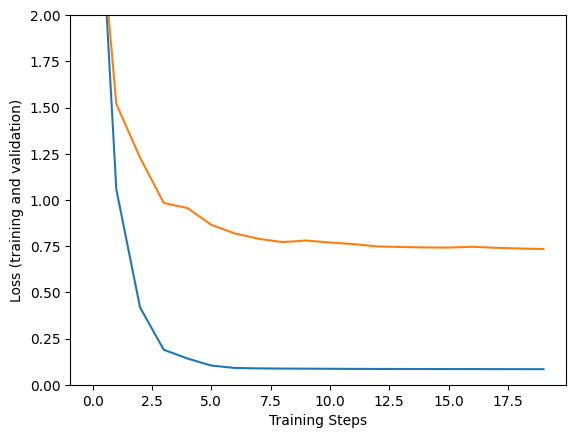

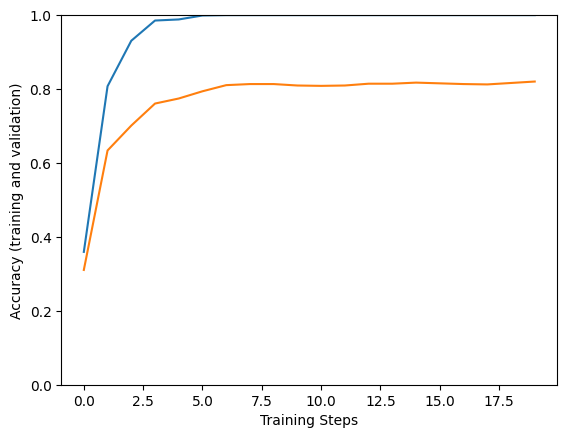

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
#guardar el modelo guardado
from google.colab import drive
drive.mount('/content/drive')

model.save('/content/drive/My Drive/Curso_IA/modelo_entrenado.h5')